In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import scienceplots
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import StateSpace, lsim
from torch import nn
import torch
import torchvision
plt.rcParams.update({
    "text.usetex": True,
    })



In [78]:
#create own aprbs signal 

def APRBS(t, amin = -1, amax = 1, holdmin=1, holdmax=25):
    
    samples_left = len(t)
    dt = t[1]-t[0]
    buf = np.array([])
    stacked_N = 0
    debug_counter = 1

    while samples_left > holdmin/dt:
        amplitude = np.random.rand()*(amax-amin) - (amax-amin)/2    #shift the uniform distribution between amin and amax
        holdtime = np.random.randint(holdmin,holdmax)
        current_N = int(holdtime/dt)
        stacked_N += current_N
        samples_left = samples_left - current_N

        if samples_left < holdmin/dt:
            break
        
        current_signal = np.ones(current_N)*amplitude
        buf = np.concatenate((buf,current_signal))
        debug_counter +=1

    amplitude = np.random.rand()*(amax-amin) - (amax-amin)/2    #shift the uniform distribution between amin and amax
    current_signal = np.ones(int(len(t) - len(buf)))*amplitude
    buf = np.concatenate((buf,current_signal)) 

    return buf 
        

    
    

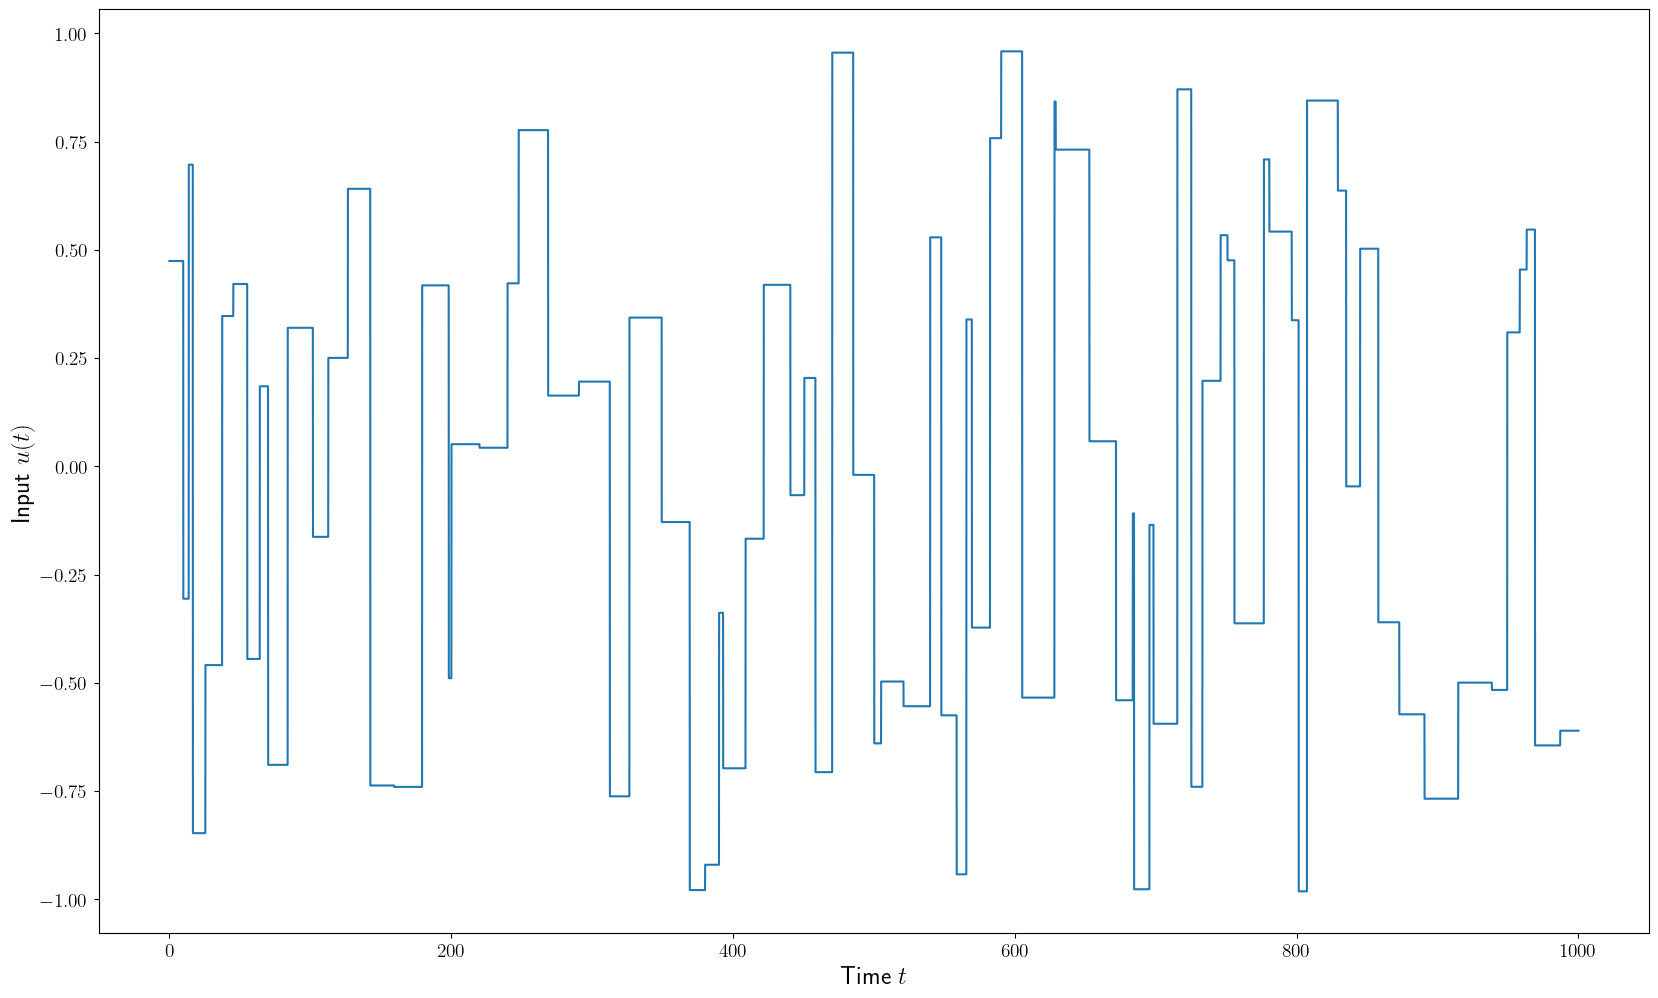

In [89]:
t = np.linspace(0,1000,10_000)
u = APRBS(t)

plt.figure(figsize=(20, 12))
plt.plot(t, u)
plt.xlabel(r'Time $t$', fontsize=18, fontfamily='serif')  # Customize fontsize and font family for x-label
plt.ylabel(r'Input $u(t)$', fontsize=18, fontfamily='serif')  # Customize fontsize and font family for y-label
# Set fontsize for x and y ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Change global font properties (optional)
#plt.rc('font', size=14, family='sans-serif')
plt.show()

In [330]:
def runSimulation(k,u):
    # parameters
    m = 0.1  # mass of the pendulum
    k_spring = 5  # spring constant
    b = 1.2  # damping coefficient
    f = 1.1  # air friction
    g = 9.81  # acceleration due to gravity
    r0 = 1  # natural length of the spring

    # system of differential equations
    def system(y, t):
        x1, x2, x3, x4 = y
        dx1 = x2
        dx2 = (m*g*np.cos(x3) - k_spring*(x1 - r0) - b*x2 + m*x1*x4**2) / m
        dx3 = x4
        dx4 = (-2*x2*x4 - g*np.sin(x3) - x3*((m*g*np.cos(x3) - k_spring*(x1 - r0) - b*x2 + m*x1*x4**2) / m) - f*x4) / (x1)
        #dx4 = (-2*x2*x4 - g*np.sin(x3)) / (x1)
        return [dx1, dx2, dx3, dx4]

    # initial conditions
    x1_0 = r0 + np.random.rand()*2  # the pendulum starts at the natural length of the spring
    x2_0 = np.random.rand()*2  # the pendulum starts at rest
    x3_0 = np.random.rand()/2  # the pendulum is slightly displaced from the vertical position
    x4_0 = np.random.rand()*2  # the pendulum starts at rest

    number_samples = 1000
    # time points
    t = np.linspace(0, 10, number_samples)

    # solve ODE
    y = odeint(system, [x1_0, x2_0, x3_0, x4_0], t)

        # numpy array manipulation
    number_states = 4
    n = number_samples-k
    #new_x = np.zeros((n,number_states*k))

    #for i in range(n):
    #    new_x[i,:] = y[i:i+k].flatten()
    new_x = y[:-k]
    new_y = y[k:]
    
    input_tensor = torch.from_numpy(new_x).float()
    target_tensor = torch.from_numpy(new_y).float()

    input_tensor = input_tensor.unsqueeze(1)  # Adding a dimension to represent sequence length
    target_tensor = target_tensor.unsqueeze(1)  # Adding a dimension to represent sequence length

    return input_tensor, target_tensor, t


In [96]:
def plot4State(t,y):
    # plot results
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.plot(t, y[:, 0])
    plt.title('Radius over time')
    plt.subplot(222)
    plt.plot(t, y[:, 1])
    plt.title('Change of radius over time')
    plt.subplot(223)
    plt.plot(t, y[:, 2])
    plt.title('Angle over time')
    plt.subplot(224)
    plt.plot(t, y[:, 3])
    plt.title('Angular velocity over time')
    plt.tight_layout()
    plt.show()

In [309]:
# neural network

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps"
device = torch.device(device)


class CustomRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CustomRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Parameters for the RNN cell
        self.Wxh = nn.Linear(input_size, hidden_size)
        self.Whh = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, h):
        combined = self.Wxh(x) + self.Whh(h)
        return torch.tanh(combined)


class MultiLayerRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MultiLayerRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define a list of custom RNN cells
        self.rnn_cells = nn.ModuleList([CustomRNNCell(input_size if i == 0 else hidden_size, hidden_size)
                                        for i in range(num_layers)])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #batch_size = x.size(0) #alt, war falsch, wieso auch immer, hat den fehler verursacht mit den hohen dimensionalitaeten
        batch_size = 1
        #print(f'batch size = {batch_size}')    #zum debuggen benutzt

        # Initialize hidden state with zeros for each layer
        hidden_states = [torch.zeros(batch_size, self.hidden_size, device=device) for _ in range(self.num_layers)]
    
        # Forward through multiple RNN layers
        for layer_idx in range(self.num_layers):
            # Get the current RNN cell
            rnn_cell = self.rnn_cells[layer_idx]

            # Forward through the RNN cell
            hidden_states[layer_idx] = rnn_cell(x if layer_idx == 0 else hidden_states[layer_idx - 1],
                                                hidden_states[layer_idx])

        # Take the output from the last layer
        out = self.fc(hidden_states[-1])
        return out


In [310]:
# initialize the neural network and set hyperparams
number_states = 4
k = 1  # number of timesteps we look back 

input_dim = number_states * k
output_dim = number_states
hidden_dim = 8
num_layers = 4

model = MultiLayerRNN(input_dim, hidden_dim, output_dim, num_layers).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.99)
criterion = nn.MSELoss()

In [311]:
input_tensor, target_tensor, t = runSimulation(1)
print(f'input_tensor has shape: {input_tensor.shape}')
print(f'target_tensor has shape: {target_tensor.shape}')

input_tensor has shape: torch.Size([995, 1, 4])
target_tensor has shape: torch.Size([995, 1, 4])


In [312]:
## initiate training phase
number_systems = 10 #number of different systems we use to train oon

for i in range(number_systems):

    input_tensor, target_tensor, t = runSimulation(1)

    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)

    num_epochs = 500
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_tensor)
        loss = criterion(outputs, target_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Round {i+1}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


Round 1, Epoch [100/500], Loss: 0.09443029761314392
Round 1, Epoch [200/500], Loss: 0.025240236893296242
Round 1, Epoch [300/500], Loss: 0.005389797035604715
Round 1, Epoch [400/500], Loss: 0.002035856479778886
Round 1, Epoch [500/500], Loss: 0.0012367138406261802
Round 2, Epoch [100/500], Loss: 0.0003140828339383006
Round 2, Epoch [200/500], Loss: 0.0002681759069673717
Round 2, Epoch [300/500], Loss: 0.00019169483857695013
Round 2, Epoch [400/500], Loss: 0.00016629650781396776
Round 2, Epoch [500/500], Loss: 0.00014364338130690157
Round 3, Epoch [100/500], Loss: 0.000499013636726886
Round 3, Epoch [200/500], Loss: 0.0003235486801713705
Round 3, Epoch [300/500], Loss: 0.0002511788625270128
Round 3, Epoch [400/500], Loss: 0.00019430233805906028
Round 3, Epoch [500/500], Loss: 0.00015080593584571034
Round 4, Epoch [100/500], Loss: 0.001084987074136734
Round 4, Epoch [200/500], Loss: 0.0006285494891926646
Round 4, Epoch [300/500], Loss: 0.00043987497338093817
Round 4, Epoch [400/500], Los

In [313]:
### evaluate the model on test set

model.eval()

input_tensor_test, target_tensor_test, t = runSimulation(1)
input_tensor_test = input_tensor_test.to(device)
target_tensor_test = target_tensor_test.to(device)

# Get predictions from the model
with torch.no_grad():
    predicted_output = model(input_tensor_test)

# Convert predicted_output tensor to numpy array
predicted_output_np = predicted_output.cpu().numpy()
actual_target_np = target_tensor_test.cpu().numpy()

In [314]:
predicted_output_np.shape
actual_target_np.shape

(995, 1, 4)

In [338]:
plt.figure(figsize=(20, 12))
k=1
plt.subplot(2,2,1)
plt.plot(t[k:],predicted_output_np[:,0,0], label=r'$\hat{x}_1$', linestyle='--')
plt.plot(t[k:],actual_target_np[:,0,0],label=r"$x_1$")
plt.xlabel('Time')
plt.ylabel('Predicted state x1')
plt.legend()

plt.subplot(2,2,2)
plt.plot(t[k:],predicted_output_np[:,0,1], label=r'$\hat{x}_2$', linestyle='--')
plt.plot(t[k:],actual_target_np[:,0,1],label=r"$x_2$")
plt.xlabel('Time')
plt.ylabel('Predicted state x2')
plt.legend()

plt.subplot(2,2,3)
plt.plot(t[k:],predicted_output_np[:,0,2], label=r'$\hat{x}_3$', linestyle='--')
plt.plot(t[k:],actual_target_np[:,0,2],label=r"$x_3$")
plt.xlabel('Time')
plt.ylabel('Predicted state x3')
plt.legend()  

plt.subplot(2,2,4)
plt.plot(t[k:],predicted_output_np[:,0,3], label=r'$\hat{x}_4$', linestyle='--')
plt.plot(t[k:],actual_target_np[:,0,3],label=r"$x_4$")
plt.xlabel('Time')
plt.ylabel('Predicted state x4')
plt.legend()

plt.show()

/var/folders/lq/blpghcxd0b9cm2tsrvlqq9g40000gn/T/ipykernel_63656/563153282.py:31: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:
plot4State(t,)

In [291]:
# run test on different hyperparams
# dic that saves loss for different hyperparams
"""
loss_dict = {}
counter = 0
hidden_dim_list = [2,4,8,12]
num_layers_list = [2,4,6,8]
lr_list = [0.01,0.005,0.02,0.001,0.1]
num_epochs_list = [100,200,500,1000]
num_systems_list = [5,10,20]

amount_hyperparams = len(hidden_dim_list)*len(num_layers_list)*len(lr_list)*len(num_epochs_list)*len(num_systems_list)

# different hyperparams [hidden_dim, num_layers, lr, num_epochs, num_systems]
for hidden_dim in hidden_dim_list:
    for num_layers in num_layers_list:
        for lr in lr_list:
            for num_epochs in num_epochs_list:
                for num_systems in num_systems_list:
                    
                    #counter for which round we are in 
                    counter +=1
                    #### run training phase
                    for i in range(number_systems):
                        input_tensor, target_tensor, t = runSimulation(1)

                        input_tensor = input_tensor.to(device)
                        target_tensor = target_tensor.to(device)

                        for epoch in range(num_epochs):
                            optimizer.zero_grad()

                            # Forward pass
                            outputs = model(input_tensor)
                            loss = criterion(outputs, target_tensor)

                            # Backward pass and optimization
                            loss.backward()
                            optimizer.step()

                            if (epoch + 1) % (num_epochs/5) == 0:
                                print(f'Round {i+1}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}    ROUND {counter}/{amount_hyperparams}')

                    ### run test phase:
                    avg_loss = 0
                    num_test_iterations = 10
                    for i in range(num_test_iterations):
                        model.eval()

                        input_tensor_test, target_tensor_test, t = runSimulation(1)
                        input_tensor_test = input_tensor_test.to(device)
                        target_tensor_test = target_tensor_test.to(device)

                        # Get predictions from the model
                        with torch.no_grad():
                            predicted_output = model(input_tensor_test)
                        loss = criterion(predicted_output, target_tensor_test)
                        avg_loss += loss.item()
                        
                    loss_dict[(hidden_dim, num_layers, lr, num_epochs, num_systems)] = avg_loss/num_test_iterations
"

"""                                     

Round 1, Epoch [20/100], Loss: 0.000941688078455627    ROUND 1/960
Round 1, Epoch [40/100], Loss: 0.0007692828075960279    ROUND 1/960
Round 1, Epoch [60/100], Loss: 0.0007046150276437402    ROUND 1/960
Round 1, Epoch [80/100], Loss: 0.0006700055673718452    ROUND 1/960
Round 1, Epoch [100/100], Loss: 0.0006426476174965501    ROUND 1/960
Round 2, Epoch [20/100], Loss: 0.0003545711806509644    ROUND 1/960
Round 2, Epoch [40/100], Loss: 0.00027633376885205507    ROUND 1/960
Round 2, Epoch [60/100], Loss: 0.0002624872431624681    ROUND 1/960
Round 2, Epoch [80/100], Loss: 0.0002562246809247881    ROUND 1/960
Round 2, Epoch [100/100], Loss: 0.00025028796517290175    ROUND 1/960
Round 3, Epoch [20/100], Loss: 0.0002512160281185061    ROUND 1/960
Round 3, Epoch [40/100], Loss: 0.00020154201774857938    ROUND 1/960
Round 3, Epoch [60/100], Loss: 0.0001846880913944915    ROUND 1/960
Round 3, Epoch [80/100], Loss: 0.0001783190673450008    ROUND 1/960
Round 3, Epoch [100/100], Loss: 0.0001757245

In [339]:
loss_dict

{(2, 2, 0.01, 100, 5): 0.0014943466596605503,
 (2, 2, 0.01, 100, 10): 0.0016077898868388728,
 (2, 2, 0.01, 100, 20): 0.0010678114544134588,
 (2, 2, 0.01, 200, 5): 0.0004090838468982838,
 (2, 2, 0.01, 200, 10): 0.0006620935424507479,
 (2, 2, 0.01, 200, 20): 0.00201247845106991,
 (2, 2, 0.01, 500, 5): 0.003308560424193274,
 (2, 2, 0.01, 500, 10): 0.0015908601159026147,
 (2, 2, 0.01, 500, 20): 0.005685105458542239,
 (2, 2, 0.01, 1000, 5): 0.003186655038734898,
 (2, 2, 0.01, 1000, 10): 0.0025172642197503594,
 (2, 2, 0.01, 1000, 20): 0.0003612321052059997,
 (2, 2, 0.005, 100, 5): 0.001110294477257412,
 (2, 2, 0.005, 100, 10): 0.001216757953443448,
 (2, 2, 0.005, 100, 20): 0.0023017508104203445,
 (2, 2, 0.005, 200, 5): 0.001901049435400637,
 (2, 2, 0.005, 200, 10): 0.0029572435130830856,
 (2, 2, 0.005, 200, 20): 0.001028563631916768,
 (2, 2, 0.005, 500, 5): 0.00013448153258650565,
 (2, 2, 0.005, 500, 10): 0.002662570425673039,
 (2, 2, 0.005, 500, 20): 0.0009197822917485609,
 (2, 2, 0.005, 10

In [293]:
min_value = min(loss_dict.values())  # Get the minimum value
keys_with_min_value = [key for key, value in loss_dict.items() if value == min_value]  # Get keys with the minimum value

print(f"Lowest value: {min_value} with hyperparams: \nhidden_dim = {keys_with_min_value[0][1]}, \nhidden_layers = {keys_with_min_value[0][1]}, \nlr = {keys_with_min_value[0][2]}, \nepochs = {keys_with_min_value[0][3]}, \nnum_systems = {keys_with_min_value[0][4]}")

Lowest value: 0.0001333967586106155 with hyperparams: 
hidden_dim = 8, 
hidden_layers = 8, 
lr = 0.005, 
epochs = 1000, 
num_systems = 10


In [294]:
keys_with_min_value[0][2]

0.005

2.5 min for 32 iterations
with epoch 100, 200
num list, 5,10

32*300*15

In [295]:
32*300*15

144000

In [325]:
l  = []
for i in range(16):
    l.append(np.random.rand(100,4))

l

[array([[9.78325099e-01, 4.49545076e-01, 8.67088813e-01, 7.46638819e-01],
        [6.70623146e-01, 7.55772224e-01, 9.99204167e-01, 4.61878954e-01],
        [5.17458663e-01, 3.82858278e-02, 1.40055343e-01, 9.22752315e-01],
        [9.23849008e-01, 2.89566539e-01, 5.58704664e-01, 6.23107003e-01],
        [7.59189787e-01, 7.15921502e-01, 3.87592356e-01, 1.88728885e-03],
        [5.99115688e-01, 6.50262777e-01, 7.92533920e-01, 2.70171653e-01],
        [8.47883476e-01, 9.40746057e-01, 6.78793728e-01, 9.73996305e-01],
        [6.68393523e-01, 3.61599587e-01, 7.54234490e-01, 7.71732115e-01],
        [4.57403474e-01, 4.99456131e-01, 3.36157902e-01, 1.29533810e-01],
        [2.21902666e-01, 4.79144550e-01, 3.54813445e-01, 7.26685844e-01],
        [3.61015914e-01, 7.11263608e-01, 3.22150729e-01, 8.78135499e-01],
        [5.50404363e-01, 9.63632073e-01, 1.64663810e-01, 7.26592504e-01],
        [8.38220490e-01, 8.91511499e-01, 3.41049614e-01, 8.22289378e-01],
        [9.44998246e-01, 8.67484214e-0

In [326]:
a = np.stack(l,axis=1)
a

array([[[0.9783251 , 0.44954508, 0.86708881, 0.74663882],
        [0.193625  , 0.33644055, 0.10212929, 0.11872175],
        [0.2274509 , 0.32361411, 0.51921719, 0.85508022],
        ...,
        [0.32784561, 0.55137731, 0.82057556, 0.07356382],
        [0.73967522, 0.07416899, 0.4689995 , 0.29010993],
        [0.13431549, 0.79661602, 0.55988109, 0.1361501 ]],

       [[0.67062315, 0.75577222, 0.99920417, 0.46187895],
        [0.76376414, 0.08396658, 0.28997171, 0.32029991],
        [0.46818013, 0.798006  , 0.7350829 , 0.7841093 ],
        ...,
        [0.7386523 , 0.56257515, 0.06574407, 0.30036512],
        [0.09455065, 0.12016384, 0.72453777, 0.1919144 ],
        [0.6285986 , 0.24505903, 0.70945923, 0.54064195]],

       [[0.51745866, 0.03828583, 0.14005534, 0.92275232],
        [0.41963701, 0.19605833, 0.98155147, 0.40257328],
        [0.62531285, 0.88601189, 0.97306933, 0.2705673 ],
        ...,
        [0.28448805, 0.24356992, 0.69100304, 0.69047692],
        [0.84348684, 0.084322

In [327]:
a.shape

(100, 16, 4)

In [336]:
input_tensor_test, target_tensor_test, t = runSimulation(1)
input_tensor_test = input_tensor_test.to(device)
target_tensor_test = target_tensor_test.to(device)

# Get predictions from the model
with torch.no_grad():
    predicted_output = model(input_tensor_test)

# Convert predicted_output tensor to numpy array
predicted_output_np = predicted_output.cpu().numpy()
actual_target_np = target_tensor_test.cpu().numpy()


import matplotlib.pyplot as plt

# Use the 'pgf' backend
plt.switch_backend('pgf')

k=1
plt.subplot(2,2,1)
plt.plot(t[k:],predicted_output_np[:,0,0], label=r'$\hat{x}_1$', linestyle='--')
plt.plot(t[k:],actual_target_np[:,0,0],label=r"$x_1$")
plt.xlabel('Time')
plt.ylabel('Predicted state x1')
plt.legend()

plt.subplot(2,2,2)
plt.plot(t[k:],predicted_output_np[:,0,1], label=r'$\hat{x}_2$', linestyle='--')
plt.plot(t[k:],actual_target_np[:,0,1],label=r"$x_2$")
plt.xlabel('Time')
plt.ylabel('Predicted state x2')
plt.legend()

plt.subplot(2,2,3)
plt.plot(t[k:],predicted_output_np[:,0,2], label=r'$\hat{x}_3$', linestyle='--')
plt.plot(t[k:],actual_target_np[:,0,2],label=r"$x_3$")
plt.xlabel('Time')
plt.ylabel('Predicted state x3')
plt.legend()  

plt.subplot(2,2,4)
plt.plot(t[k:],predicted_output_np[:,0,3], label=r'$\hat{x}_4$', linestyle='--')
plt.plot(t[k:],actual_target_np[:,0,3],label=r"$x_4$")
plt.xlabel('Time')
plt.ylabel('Predicted state x4')
plt.legend()

plt.show()
plt.savefig("beispielplot.pgf")

/var/folders/lq/blpghcxd0b9cm2tsrvlqq9g40000gn/T/ipykernel_63656/2008707390.py:48: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()
